# 导入必要的工具包

In [1]:
#sk里面的实现
from xgboost import XGBClassifier
#单独实现
import xgboost as xgb
#读取文件的类
import pandas as pd
#矩阵的类
import numpy as np
#交叉验证的类
from sklearn.model_selection import GridSearchCV
#分层采样的类
from sklearn.model_selection import StratifiedKFold
#评分标准 log似然损失
from sklearn.metrics import log_loss
#画图的类
from matplotlib import pyplot
import seaborn as sns
%matplotlib inline

# 读取数据

In [2]:
#读取csv文件
train = pd.read_csv("RentListingInquries_FE_train.csv")
#显示头5行信息
train.head()

,bathrooms,bedrooms,price,price_bathrooms,price_bedrooms,room_diff,room_num,Year,Month,Day,...,walk,walls,war,washer,water,wheelchair,wifi,windows,work,interest_level
0,1.5,3,3000,1200.0,750.000000,-1.5,4.5,2016,6,24,...,0,0,0,0,0,0,0,0,0,1
1,1.0,2,5465,2732.5,1821.666667,-1.0,3.0,2016,6,12,...,0,0,0,0,0,0,0,0,0,2
2,1.0,1,2850,1425.0,1425.000000,0.0,2.0,2016,4,17,...,0,0,0,0,0,0,0,0,0,0
3,1.0,1,3275,1637.5,1637.500000,0.0,2.0,2016,4,18,...,0,0,0,0,0,0,0,0,0,2
4,1.0,4,3350,1675.0,670.000000,-3.0,5.0,2016,4,28,...,0,0,1,0,0,0,0,0,0,2


In [3]:
#查看详细信息
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49352 entries, 0 to 49351
Columns: 228 entries, bathrooms to interest_level
dtypes: float64(9), int64(219)
memory usage: 85.8 MB


In [4]:
#查看是否有空值
train.isnull()

,bathrooms,bedrooms,price,price_bathrooms,price_bedrooms,room_diff,room_num,Year,Month,Day,...,walk,walls,war,washer,water,wheelchair,wifi,windows,work,interest_level
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
6,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
7,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
8,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


没有发现空值的情况

# 查看样本分布是否均匀

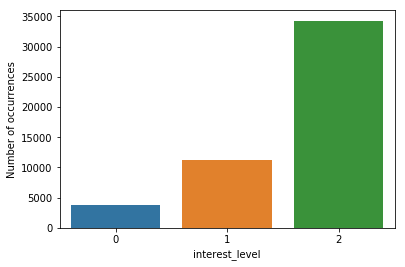

In [5]:
#拿出y轴的结果画图
sns.countplot(train.interest_level);
#设置x轴的名字
pyplot.xlabel('interest_level');
#设置y轴的名字
pyplot.ylabel('Number of occurrences');

不够均匀，非常感兴趣的占大多数

# 拿到训练集数据的X核y轴

In [6]:
#拿到y轴的值
y_train = train['interest_level']
#从训练集中删除y轴interest_level
train = train.drop(["interest_level"], axis=1)
#把训练集变为矩阵
X_train = np.array(train)


# 因为数据量不均匀  要按比例采样

In [7]:
#实例化分层采样的类
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=3)
#n_splits=5 切割5次
#shuffle=True  是否进行落地计算
#random_state=3 随机的次数

第一轮参数调整得到的n_estimators最优值（299），其余参数继续默认值

用交叉验证评价模型性能时，用scoring参数定义评价指标。评价指标是越高越好，因此用一些损失函数当评价指标时，需要再加负号，如neg_log_loss

In [8]:
#reg_alpha = [1e-3, 1e-2, 0.05, 0.1]    #default = 0
#reg_lambda = [1e-3, 1e-2, 0.05, 0.1]   #default = 1
#设置L1正则的范围  1到5之间  步长为2
reg_alpha = [ 1.5, 2]    #default = 0, 测试0.1,1，1.5，2
#设置L2正则的范围  0到5之间   步长为2
reg_lambda = [0.5, 1, 2]      #default = 1，测试0.1， 0.5， 1，2

#把参数变为map
param_test5_1 = dict(reg_alpha=reg_alpha, reg_lambda=reg_lambda)
#reg_alpha=reg_alpha  L1正则
#reg_lambda=reg_lambda  L2正则

param_test5_1


{'reg_alpha': [1.5, 2], 'reg_lambda': [0.5, 1, 2]}

In [9]:
xgb5_1 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=299,  #第二轮参数调整得到的n_estimators最优值
        max_depth=6,
        min_child_weight=4,
        gamma=0,
        subsample=0.7,
        colsample_bytree=0.6,
        colsample_bylevel = 0.7,
        objective= 'multi:softprob',
        seed=3)
#learning_rate =0.1  学习率
#n_estimators=645 弱分类器的数目
#max_depth=6  树的最大深度
#min_child_weight=4 叶子节点需要的最小权重
#gamma=0 节点分裂所需的最小损失函数下降值
#subsample=0.7样本采样比例
#colsample_bytree=0.6  每棵树所用的特征比例
#colsample_bylevel=0.7 树在每层每个分裂的所用特征比例
#objective= 'multi:softprob'  待优化的目标参数  多分类问题
#seed=3  随机的种子数

#实例化交叉验证的类
gsearch5_1 = GridSearchCV(xgb5_1, param_grid = param_test5_1, scoring='neg_log_loss',n_jobs=-1, cv=kfold)
#xgb5_1  模型
#param_grid = param_test5_1  封装好的  树的最大深度和叶子节点需要的最小样本权重
#scoring='neg_log_loss'  得分标准  负log似然
#n_jobs=-1  开启所有的线程
#cv=kfold  交叉验证的类

#训练数据
gsearch5_1.fit(X_train , y_train)
#X_train   训练集x轴的值
#y_train   训练集y轴的值

#输出各个分数              输出最好的值                最好的分数
gsearch5_1.grid_scores_, gsearch5_1.best_params_,     gsearch5_1.best_score_

/home/chenhafoen/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -0.58104, std: 0.00319, params: {'reg_alpha': 1.5, 'reg_lambda': 0.5},
  mean: -0.58128, std: 0.00292, params: {'reg_alpha': 1.5, 'reg_lambda': 1},
  mean: -0.58092, std: 0.00289, params: {'reg_alpha': 1.5, 'reg_lambda': 2},
  mean: -0.58071, std: 0.00312, params: {'reg_alpha': 2, 'reg_lambda': 0.5},
  mean: -0.58132, std: 0.00338, params: {'reg_alpha': 2, 'reg_lambda': 1},
  mean: -0.58076, std: 0.00298, params: {'reg_alpha': 2, 'reg_lambda': 2}],
 {'reg_alpha': 2, 'reg_lambda': 0.5},
 -0.5807088051906137)

In [10]:
#输出交叉验证的结果
gsearch5_1.cv_results_

/home/chenhafoen/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/chenhafoen/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/chenhafoen/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/chenhafoen/anac

{'mean_fit_time': array([468.2646471 , 491.71370645, 520.5252492 , 515.38232479,
        514.81984963, 411.81265864]),
 'mean_score_time': array([2.43674912, 2.19563818, 2.44604163, 2.60156183, 2.20067515,
        1.59948039]),
 'mean_test_score': array([-0.58104071, -0.58128137, -0.58091998, -0.58070881, -0.58132147,
        -0.58075738]),
 'mean_train_score': array([-0.44466548, -0.44630492, -0.44973015, -0.44748882, -0.44917645,
        -0.45278463]),
 'param_reg_alpha': masked_array(data=[1.5, 1.5, 1.5, 2, 2, 2],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_reg_lambda': masked_array(data=[0.5, 1, 2, 0.5, 1, 2],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'reg_alpha': 1.5, 'reg_lambda': 0.5},
  {'reg_alpha': 1.5, 'reg_lambda': 1},
  {'reg_alpha': 1.5, 'reg_lambda': 2},
  {'reg_alpha': 2, 'reg_lambda': 0.5},
  {'reg_alpha': 

Best: -0.580709 using {'reg_alpha': 2, 'reg_lambda': 0.5}


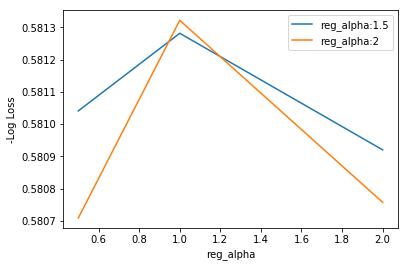

In [11]:
#输出最好的分数  和最好的参数
print("Best: %f using %s" % (gsearch5_1.best_score_, gsearch5_1.best_params_))
#拿到测试集的平均数
test_means = gsearch5_1.cv_results_[ 'mean_test_score' ]
#拿到测试集的方差
test_stds = gsearch5_1.cv_results_[ 'std_test_score' ]
#拿到训练集的平均数
train_means = gsearch5_1.cv_results_[ 'mean_train_score' ]
#拿到训练集的方差
train_stds = gsearch5_1.cv_results_[ 'std_train_score' ]
#把结果变成df 再输出为csv违建
pd.DataFrame(gsearch5_1.cv_results_).to_csv('my_preds_reg_alpha_reg_lambda_1.csv')

#拿到测试集的分数
test_scores = np.array(test_means).reshape(len(reg_alpha), len(reg_lambda))
#len(reg_alpha)  多少个数组
#len(reg_lambda)  数组里有多少个元素

train_scores = np.array(train_means).reshape(len(reg_alpha), len(reg_lambda))
#len(reg_alpha)  多少个数组
#len(reg_lambda)  数组里有多少个元素

#log_reg_alpha = [0,0,0,0]
#for index in range(len(reg_alpha)):
#   log_reg_alpha[index] = math.log10(reg_alpha[index])
    
for i, value in enumerate(reg_alpha):
    #画出图
    pyplot.plot(reg_lambda, -test_scores[i], label= 'reg_alpha:'   + str(value))
    #min_child_weight  x轴的值 叶子节点需要的最小样本权重
    #-test_scores[i]  y轴的值  评分
    #label= 'test_max_depth:'   + str(value)  标签名
    
#for i, value in enumerate(min_child_weight):
#    pyplot.plot(max_depth, train_scores[i], label= 'train_min_child_weight:'   + str(value))

#画面自适应
pyplot.legend()
#设置x轴的值
pyplot.xlabel( 'reg_alpha' )     
#设置y轴的值
pyplot.ylabel( '-Log Loss' )
#保存成图片
pyplot.savefig( 'reg_alpha_vs_reg_lambda1.png' )